Building torch.nn from scratch 

The problem with the MLP approach is that we are "crushing" all the inputs into a single layer in the begninnng, in a single step.  Although we could make the network deeper to improve the complexity, but the problem still exists . 


WaveNet does not do this "squashing" of the input. The inputs are rather crushed slowly. The information from the previous context is fused SLOWLY into the network as it gets deeper. 

At each level of the network, we're going to fuse only two consecutive elements 

In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt 
%matplotlib inline

In [4]:
words = open('names.txt','r').read().splitlines()
print(f"Number of words: {len(words)} \nExamples: {words[:8]}")

Number of words: 32033 
Examples: ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos,"\n",vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'} 
 27


In [6]:
# shuffle the words
import random
random.seed(42)
random.shuffle(words)

In [65]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append to the context 

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1]) # Training split 80%
Xdev, Ydev = build_dataset(words[n1:n2]) # Validation split 10%
Xte, Yte = build_dataset(words[n2:]) # Test split 10%

torch.Size([182437, 8]) torch.Size([182437])
torch.Size([22781, 8]) torch.Size([22781])
torch.Size([22928, 8]) torch.Size([22928])


In [66]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x ), '-->', itos[y.item()])

........ --> t
.......t --> a
......ta --> u
.....tau --> r
....taur --> e
...taure --> n
..tauren --> .
........ --> s
.......s --> u
......su --> l
.....sul --> e
....sule --> m
...sulem --> a
..sulema --> n
.suleman --> .
........ --> z
.......z --> e
......ze --> r
.....zer --> e
....zere --> n


In [105]:
class Linear: 
    def __init__(self, fan_in, fan_out, bias = True): # fan_in: # of inputs , fan_out: # of outputs 
        self.weight = torch.randn((fan_in, fan_out)) / fan_in ** 0.5 # Kaiming init
        self.bias = torch.zeros(fan_out) if bias else None 
    
    def __call__(self, x): 
        self.out = x @ self.weight
        if self.bias is not None: 
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    
    def __init__(self, dim, eps = 1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        # Params: that are trained with backprop 
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        
        # buffers: that are trained with a running 'momentum' update (exponential moving average)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self,x):
        # forward pass
        if self.training: 
            
            if x.ndim  ==2:
                dim =0
                    
            elif x.ndim ==3: # fix batchorm for this case where the input is 3 dimensional instead of 2 
                dim = (0,1)
            xmean = x.mean(dim,keepdim=True) # mean of the batch 
            xvar = x.var(dim, keepdim = True) # variance of the batch 
            
        else: 
            xmean = self.running_mean 
            xvar = self.running_var 
        
        xhat = (x-xmean) / torch.sqrt( xvar + self.eps) # normalize to unit variance, eps to avoid dividing by zero
        self.out = self.gamma * xhat + self.beta 
        
        # update
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar 

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self,x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return [] 
    
    
class Embedding: 
    
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim)) # this is the C matrix  
    
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]
    
    
class FlattenConsecutive: # not exactly same as PyTorch's flatten 
    def __init__(self,n):
        # n is the number of consecutive elements we want to pair (concatenate)
        self.n = n
    
    def __call__(self,x):
        B,T,C = x.shape 
        x = x.view(B, T//self.n, self.n*C)
        
        if x.shape[1] == 1:
            x = x.squeeze(1)
            
        self.out = x
        return self.out
    
    def parameters(self):
        return [] 
    

# Implementing PyTorch's containers 

class Sequential: 
    def __init__(self,layers):
        self.layers = layers
        
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out 
    
    def parameters(self):
        # get params of all the layers and strech them into a single list 
        return [p for layer in self.layers for p in layer.parameters()]

In [106]:
torch.manual_seed(42);


In [107]:
n_embd = 10 # dimensionality of the character embedding vectors 
n_hidden = 68 # number of neurons in the hidden layer of the MLP 


model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2),Linear(n_embd * 2, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2),Linear(n_hidden * 2, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2),Linear(n_hidden * 2, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),


    Linear(n_hidden, vocab_size),
])


with torch.no_grad():
    # last layer: make it less confident
    layers[-1].weight *= 0.1
            
            
parameters = model.parameters()
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True


22397


In [108]:
# ix = torch.randint(0,Xtr.shape[0],(4,))
# Xb,Yb = Xtr[ix] , Ytr[ix]
# logits = model(Xb)
# print(Xb.shape)
# Xb

In [109]:
# for layer in model.layers:
#     print(layer.__class__.__name__,':', tuple(layer.out.shape))

In [110]:
# Optimization same as before 
max_steps = 200_000
batch_size = 32
lossi = []


for i in range(max_steps):
    
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # minibatch X and Y 
    
    # Forward pass
    logits = model(Xb)xw

    loss = F.cross_entropy(logits, Yb)
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update : SGD 
    lr = 0.1 if i < 150_000 else 0.01 # Step learning rate decay 
    for p in parameters:
        p.data += -lr * p.grad # The "update"
        
    # Track stats
    if i%10_000 == 0: # Print every 10k steps 
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    


      0/ 200000: 3.4985
  10000/ 200000: 2.6351
  20000/ 200000: 1.7178
  30000/ 200000: 2.0024
  40000/ 200000: 2.2727
  50000/ 200000: 2.1194
  60000/ 200000: 2.3659
  70000/ 200000: 1.6179
  80000/ 200000: 1.9928
  90000/ 200000: 1.8687
 100000/ 200000: 1.9310
 110000/ 200000: 2.2240
 120000/ 200000: 2.1806
 130000/ 200000: 1.7530
 140000/ 200000: 1.9966
 150000/ 200000: 1.8820
 160000/ 200000: 1.8997
 170000/ 200000: 1.9224
 180000/ 200000: 1.9073
 190000/ 200000: 1.5848


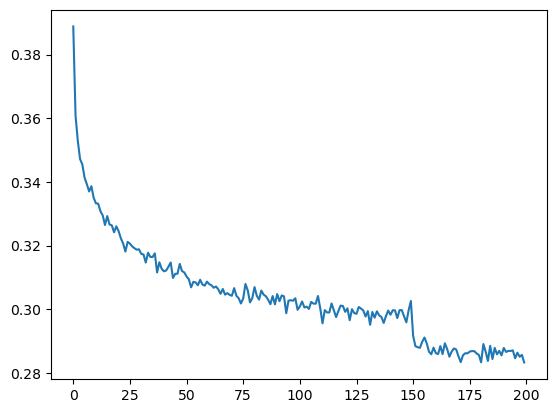

In [111]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1)) # strech out the for 1000 consecutive elements 
# Take average for every 1000 iterations 

In [112]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
    layer.training = False

In [113]:
@torch.no_grad() # Disable gradient tracking 
def split_loss(split):
    x,y = {
        'train': (Xtr,Ytr),
        'val': (Xdev,Ydev),
        'test': (Xte, Yte),
    }[split]
    
    logits = model(x)
        
    loss = F.cross_entropy(logits, y)
    print(f'{split} loss: {loss.item()}')
    
split_loss('train')
split_loss('val')


train loss: 1.911442518234253
val loss: 2.0323798656463623


In [115]:
# Sample from the model and generate names 
for _ in range(20):    
    out = []
    context = [0] * block_size # init with all "..."
    while True: 
        # forward pass the neural net 
        logits = model(torch.tensor([context]))
        
        
        probs = F.softmax(logits , dim = 1)
        
        ix = torch.multinomial(probs, num_samples = 1).item()   # sample from the distribution 
        context = context[1:] + [ix] # shift the context window and track the samples
        out.append(ix)
        # if the '.' is sampled, then finish
        if ix == 0: 
            break
     
    print("".join(itos[i] for i in out))

tokore.
yohna.
nichira.
hayleigh.
brakel.
shyvan.
luna.
aleysh.
kelon.
luwa.
archan.
jennesty.
brarai.
raney.
maleni.
jari.
nezariannah.
preszopard.
joreri.
bascer.
